# TO-DO:

### Read in master station list

### Look at how number of offshore stations changes through time

### Pick an hour!

### Write a function that creates a station list based on various choices (time, network, elevation, etc.)

### Write a function that loops through 30 s at a time downloading waveforms from a given station list
- Dask? Parallelize?

### Save the downloaded hour of waveforms

### Write a function that calls to PhaseNet through QuakeFlow API using downloaded waveforms, test how long it takes

### Write a function that calls to PhaseNet using Seisbench, test how long it takes

In [5]:
!mamba env create --quiet -f environment.yml

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK

done
Installing pip dependencies: ...working... done


In [34]:
import obspy
import obsplus
import pandas as pd
from obspy.clients.fdsn import Client
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import logging
import requests
import seisbench
import seisbench.models as sbm
import dask
import json

## Read in master station list

In [35]:
# Load master station list
dfS = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_stations.parquet')

# Convert to pandas datetime
dfS['start_date']=pd.to_datetime(dfS['start_date'],infer_datetime_format=True,errors='coerce')
dfS['end_date']=pd.to_datetime(dfS['end_date'],infer_datetime_format=True,errors='coerce')

## Look at how number of offshore stations changes through time

In [36]:
# Count up how many offshore stations are operating per day

offshore = dfS[dfS['elevation(m)']<-10]

start_date = datetime.datetime(2018,5,1)
end_date = datetime.datetime(2020,1,1)

days = (end_date - start_date).days

count = []
for i in range(days):
    t1 = start_date + pd.Timedelta(i,'days')
    t2 = start_date + pd.Timedelta(i+1,'days')


    count.append(((offshore['start_date'] < t1) & (offshore['end_date'] > t2)).sum())

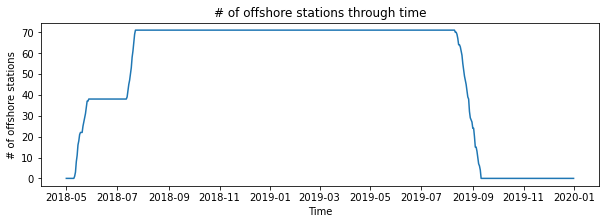

In [37]:
# Plot up that count to see how it changes through time

%matplotlib inline
plt.figure(figsize=(10, 3))
plt.plot(np.arange(start_date,end_date,pd.Timedelta(1,'days')),count)
plt.xlabel('Time'); plt.ylabel('# of offshore stations')
plt.title('# of offshore stations through time')
plt.show()

## Pick a time!

In [5]:
# Let's pick a time. This one has 34 stations, and a magnitude 3 earthquake:

t1 = datetime.datetime(2018,5,25,12,30)
t2 = t1 + pd.Timedelta(1,'days')

((offshore['start_date'] < t1) & (offshore['end_date'] > t2)).sum()

37

## Now we'll make a station sublist.

In [38]:
def station_list(dfS,t1,t2,elevation=False,network=False):
    """ Function to make a station sublist from the master station list based on several choices
    
    INPUTS:
    dfS - pandas dataframe of station information for the entire AACSE catalog
    t1,t2 - datetime objects; only return stations operating between these two timestamps
    elevation - float; only return stations below this maximum elevation
    network - string; only return stations within this network
    """
    
    dfS = dfS[(dfS['start_date'] < t1) & (dfS['end_date'] > t2)]
    
    
    if elevation:
        dfS = dfS[dfS['elevation(m)']<elevation]
        
    if network:
        dfS = dfS[dfS['network']==network]
    
    return dfS

In [43]:
# Make our sublist!

sub = station_list(dfS,t1,t2,elevation=-10)

## Function to retrieve waveforms for a given station list:

In [40]:
def retrieve_waveforms(dfS,t1,t2,sampling_rate=100):
    

    client = Client("iris")
    
    df = dfS.loc[:,['network','station']]
    df['location']='*'
    df['channels']=dfS.id.str[-2:]+'*'
    df['start']=obspy.UTCDateTime(t1)
    df['end']=obspy.UTCDateTime(t2)

    bulk_order = df.to_records(index=False).tolist()
    
    st = client.get_waveforms_bulk(bulk_order)
    
    # Detrend all traces:
    try:
        st = st.detrend("spline", order=2, dspline=5 * st[0].stats.sampling_rate)
    except:
        # logging.error(f"Error: spline detrend failed at file {fname}")
        st = st.detrend("demean")
    
    # Make sure all traces are the same length by padding with zeros:
    st = st.merge(fill_value=0)
    st = st.trim(obspy.UTCDateTime(t1),obspy.UTCDateTime(t2), pad=True, fill_value=0)
    
        # Double check that everything is the same sampling rate:
    for i in range(len(st)):
        if st[i].stats.sampling_rate != sampling_rate:
            st[i] = st[i].interpolate(sampling_rate, method="linear")
            


    
    return st


## Parallelize a call to loop over 30 s at a time, retrieving waveforms:

In [55]:
t1 = datetime.datetime(2018,5,25,12,36,30)
t2 = t1 + pd.Timedelta(1,'hour')

sub = station_list(dfS,t1,t2,elevation=300)
time_bins = pd.to_datetime(np.arange(t1,t2,pd.Timedelta(30,'seconds')))


@dask.delayed
def loop_times(dfS,t1,step):
    return retrieve_waveforms(dfS,t1,t1+pd.Timedelta(step,'seconds'))

lazy_results = [loop_times(sub,time,30) for time in time_bins]

In [56]:
%%time

# NOTES:
# 3 min 52 s for 1 hour for elevation of -10!
# 14 min for 1 hour for elevation of 300!
# 7 min 52 s for 2 hours!
# 47 min for 12 hours!
# NOTE: timeout error when try to do a whole day

results = dask.compute(lazy_results)

CPU times: user 1min 51s, sys: 12.4 s, total: 2min 4s
Wall time: 14min 22s


## Convert output to a list of streams. Each stream is for a given 30 second window. 

In [57]:
streams = results[0]

## Save to mseed for safekeeping:

In [117]:
streams.write("alaska_1hour.mseed", format="MSEED")  

AttributeError: 'list' object has no attribute 'write'

## Phase pick using PhaseNet via QuakeFlow:

In [48]:
def pick_quakeflow(st,dfS,remove_resp=False):
    """
    Runs a 30-s obspy stream through PhaseNet using QuakeFlow
    
    1. Converts stream to a set of numpy arrays
    """
    
    sampling_rate = 100
    n_channel = 3
    dtype = "float32"
    amplitude = True
    
    

    starttime = min([p.stats.starttime for p in st])
    endtime = min([p.stats.endtime for p in st])
    
    # Double check that everything is the same sampling rate:
    for i in range(len(st)):
        if st[i].stats.sampling_rate != sampling_rate:
            # logging.warning(
            #     f"Resampling {st[i].id} from {st[i].stats.sampling_rate} to {sampling_rate} Hz"
            # )
            st[i] = st[i].interpolate(sampling_rate, method="linear")
    
    # Set up an order to loop through the traces
    order = ['3', '2', '1', 'E', 'N', 'Z']
    order = {key: i for i, key in enumerate(order)}
    comp2idx = {"3": 0, "2": 1, "1": 2, "E": 0, "N": 1, "Z": 2}
    
    nsta = len(dfS)
    nt = max(len(st[i].data) for i in range(len(st)))
    data = []
    station_id = []
    t0 = []
    
        # Loop through traces
        #for i in range(len(st)):
         #   trace_data = np.zeros([nt, n_channel], dtype=dtype)
          #  empty_station = True
           # sta_id = st[i].meta.network + '.' + st[i].meta.station + '..'+ st[i].meta.channel[0:2]

       # t1 = st[i].stats.starttime
       # t2 = st[i].stats.endtime
        
       # sta = dfS[dfS['id']==sta]
       # comp = sta.iloc[0].split(",")
        
       # if remove_resp:
       #     resp = sta.iloc[0]["response"].split(",")
            
            
        
    # Loop through stations and time bands
    
    for i in range(nsta):
        trace_data = np.zeros([nt, n_channel], dtype=dtype)
        empty_station = True
        # sta = station_locs.iloc[i]["station"]
        sta = dfS.id[i]
        comp = dfS.iloc[i]["component"].split(",")
        if remove_resp:
            resp = dfS.iloc[i]["response"].split(",")
            # resp = station_locs.iloc[i]["response"]

        for j, c in enumerate(sorted(comp, key=lambda x: order[x[-1]])):
            
            if remove_resp:
                resp_j = float(resp[j])
            
            
            if len(comp) != 3:  ## less than 3 component
                j = comp2idx[c]

            if len(st.select(id=sta + c)) == 0:
                # print(f"Empty trace: {sta+c} {starttime}")
                continue
            else:
                empty_station = False

            tmp = st.select(id=sta + c)[0].data.astype(dtype)
            trace_data[: len(tmp), j] = tmp[:nt]

            if dfS.iloc[i]["unit"] == "m/s**2":
                tmp = st.select(id=sta + c)[0]
                tmp = tmp.integrate()
                tmp = tmp.filter("highpass", freq=1.0)
                tmp = tmp.data.astype(dtype)
                trace_data[: len(tmp), j] = tmp[:nt]
            elif dfS.iloc[i]["unit"] == "m/s":
                tmp = st.select(id=sta + c)[0].data.astype(dtype)
                trace_data[: len(tmp), j] = tmp[:nt]
            else:
                print(
                    f"Error in {station_locs.iloc[i]['station']}\n{station_locs.iloc[i]['unit']} should be m/s**2 or m/s!"
                )
            
            if remove_resp:
                trace_data[:, j] /= resp_j
                
        if not empty_station:
            data.append(trace_data)
            station_id.append(sta)
            t0.append(starttime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3])

    data = np.stack(data)
    
    # Make dictionary with data in numpy arrays, tied to station and time:
    meta = {"data": data, "t0": t0, "station_id": station_id, "fname": station_id}
    
    # Use that to call to QuakeFlow API
    
    PHASENET_API_URL = "http://phasenet.quakeflow.com"

    batch = 4
    phasenet_picks = []
    for j in range(0, len(meta["station_id"]), batch):
        req = {"id": meta['station_id'][j:j+batch],
            "timestamp": meta["t0"][j:j+batch],
            "vec": meta["data"][j:j+batch].tolist()}

        resp = requests.post(f'{PHASENET_API_URL}/predict', json=req)
        phasenet_picks.extend(resp.json())
    
    print(phasenet_picks)
    picks = pd.DataFrame(phasenet_picks)
    
    return phasenet_picks

    
    

## Call to PhaseNet via QuakeFlow by looping over each 30-s stream in parallel

In [58]:
@dask.delayed
def loop_phasenet(stream,sub):
    return pick_quakeflow(stream,sub,remove_resp=True)

lazy_results = [loop_phasenet(stream,sub) for stream in streams]

In [59]:
%%time
results = dask.compute(lazy_results)

## NOTE: 4 min 18 s to run through 1 hour of data

[{'id': 'AK.CHN..BH', 'timestamp': '2018-05-25T12:45:58.134', 'prob': 0.4155454635620117, 'amp': 7.203385621323832e-07, 'type': 'p'}, {'id': 'AK.CHN..BN', 'timestamp': '2018-05-25T12:45:57.924', 'prob': 0.3096800446510315, 'amp': 2.8023632125950826e-07, 'type': 'p'}, {'id': 'AK.SWD..BN', 'timestamp': '2018-05-25T12:45:30.004', 'prob': 0.3976499140262604, 'amp': 4.711704093551816e-07, 'type': 'p'}, {'id': 'AT.YKU2..BH', 'timestamp': '2018-05-25T12:45:44.134', 'prob': 0.32047292590141296, 'amp': 7.614663900312735e-06, 'type': 'p'}, {'id': 'TA.N14K..BH', 'timestamp': '2018-05-25T12:45:59.304', 'prob': 0.36342138051986694, 'amp': 3.199041884727194e-07, 'type': 'p'}, {'id': 'XO.WS27..HN', 'timestamp': '2018-05-25T12:45:30.004', 'prob': 0.36550694704055786, 'amp': 5.562662863667356e-07, 'type': 'p'}]
[{'id': 'XO.LA28..HH', 'timestamp': '2018-05-25T13:28:59.774', 'prob': 0.35361626744270325, 'amp': 1.2720314771286212e-05, 'type': 's'}, {'id': 'XO.LA29..HH', 'timestamp': '2018-05-25T13:28:59.5

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

## Concat results into a list of pick dictionaries, for GAMMA

In [53]:
phasenet_picks = []
for pick in results[0]:
    phasenet_picks.extend(pick)

## Send picks to GAMMA for association
#### Note: may want to split this or run it in parallel in the future

In [54]:
%%time
config = {}
config["xlim_degree"] = [-170,-140]
config["ylim_degree"] = [50,65]

GAMMA_API_URL = "http://gamma.quakeflow.com"

# stations_json = json.loads(station_locs.to_json(orient="records"))
flat_sub = sub.copy()
flat_sub['start_date'] = flat_sub['start_date'].dt.strftime('%Y-%m-%d')
flat_sub['end_date'] = flat_sub['end_date'].dt.strftime('%Y-%m-%d')
stations_json = flat_sub.to_dict(orient="records")
config_gamma = {'xlim_degree': config["xlim_degree"], 
                'ylim_degree': config["ylim_degree"],
                'z(km)': [0, 41]}

result = requests.post(f'{GAMMA_API_URL}/predict', json= {"picks": phasenet_picks, 
                                                          "stations": stations_json,
                                                           "config": config_gamma})

result = result.json()

CPU times: user 13.8 ms, sys: 3.94 ms, total: 17.8 ms
Wall time: 304 ms


## Save for evaluation

In [122]:
save_file = 'result_example'

with open(save_file+'.json', 'w') as f:
    json.dump(result, f)

## Phase pick using PhaseNet via SeisBench:

## NOTE: the pretrained models don't load from the planetary computer. Need to try this locally.

Documented here: https://github.com/seisbench/seisbench#known-issues

In [188]:
# Seisbench just runs on an obspy stream. 
# st = st.filter('bandpass',freqmin=5,freqmax=35)
# st = st.taper(max_percentage=0.2)
model = sbm.PhaseNet.from_pretrained("STEAD")
annotations = model.annotate(st)

2022-01-27 11:01:55,002 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-01-27 11:01:55,004 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-01-27 11:01:55,038 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-01-27 11:01:55,056 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-01-27 11:01:55,085 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.


In [189]:
model.classify(annotations)

[]

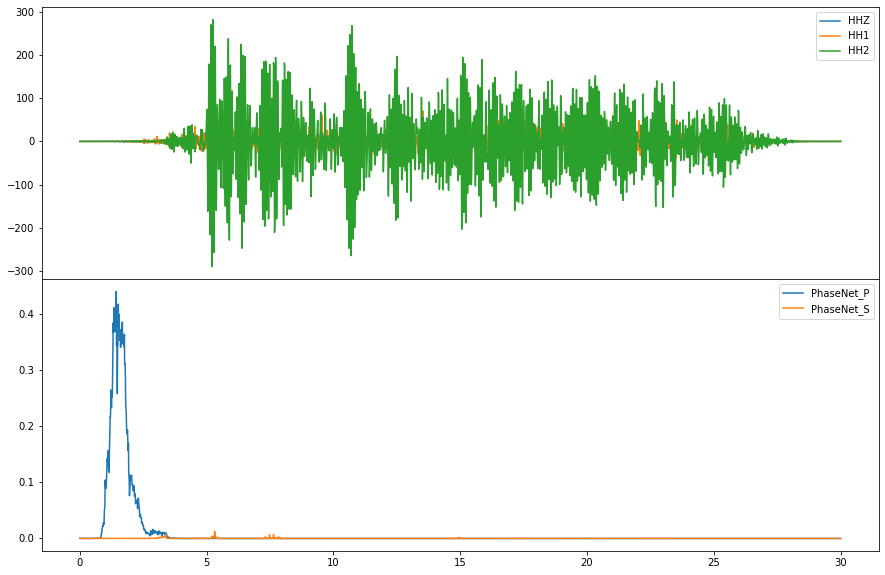

In [191]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - st[0].stats.starttime
for i in [9,10,11]:
    axs[0].plot(st[i].times(), st[i].data, label=st[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
# axs[0].set_ylim([-5,5])
axs[1].legend()

In [ ]:
import postprocess

detect_peaks(pred[:,j,1], mph=mph_p, mpd=mpd, show=False)



picks = postprocess.extract_picks(annotations[0].data)